In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of sRNA in mRNA targetting

## Imports

In [2]:
import os
from subprocess import Popen, PIPE, run
from datetime import datetime
import pandas as pd

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Load data

In [3]:
fn_merged_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
data = pd.read_csv(fn_merged_inter)
try:
    data = data.drop(columns=['Unnamed: 0', 'level_0'])
except:
    pass

data = data[~data['Sequence 1'].isna()]
data = data[~data['Sequence 2'].isna()]

In [4]:
print(len(data))
nn = np.sum(np.arange(1, len(data)+1)) + len(data)
print('Expected number of species: ', nn)
data

446
Expected number of species:  100127


,Unnamed: 0,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB
0,44,micA,dppA,NCBI:2847697,NCBI:948062,sRNA,mRNA,NaN,NaN,NaN,CAAAAATGGTGTCGCTCGTATTATTGTCGAGAAACCTTTCGGCAAG...,ATGCGTATTTCCTTGAAAAAGTCAGGGATGCTGAAGCTTGGTCTCA...,RNAInter
1,50,dsrA,dsrB,NCBI:946470,NCBI:946468,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,TAAATGNAAACAAGTTTTATTTTTATCATCAGAACATTCTAATAAA...,RNAInter
2,53,dsrA,ilvH,NCBI:946470,NCBI:947267,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,RNAInter
3,63,micA,ecnB,NCBI:2847697,NCBI:2847737,sRNA,mRNA,NaN,NaN,NaN,CAAAAATGGTGTCGCTCGTATTATTGTCGAGAAACCTTTCGGCAAG...,ATGGTGAAGAAGACAATTGCAGCGATCTTTTCTGTTCTGGTGCTTT...,RNAInter
4,74,oxyS,fhlA,NCBI:2847701,NCBI:947181,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,RNAInter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,760,ryhB,msrA,"chromosome:NC_000913.3, Gene ID:2847761","chromosome:NC_000913.3, Gene ID:948734",NaN,mRNA,No Interaction,['NA'],['NA'],GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...,ATGAGTTTATTTGATAAAAAGCATCTGGTTTCCCCCGCCGATGCCC...,sRNATarBase
445,761,gcvB,hdeA,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948025",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAAAAAAGTATTAGGCGTTATTCTTGGTGGTCTGCTTCTTCTGC...,sRNATarBase
446,762,gcvB,hdeB,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948026",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAATATTTCATCTCTCCGTAAAGCGTTTATTTTTATGGGCGCTG...,sRNATarBase
447,763,Esr41,fliC,"chromosome:NC_002695.1, Gene ID:","chromosome:NC_002695.1, Gene ID:",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],GATGCTCTAGGCATCACATTTTCTCCATGGGGTATTCCCTCCGCCG...,ATGGCACAAGTCATTAATACCAACAGCCTCTCGCTGATCACTCAAA...,sRNATarBase


# Get mRNAs and sRNAs

In [5]:
# srnas = list(set(data[data['Category 1'] != 'mRNA']['Interactor 1'].to_list() + data[data['Category 2'] != 'mRNA']['Interactor 2'].to_list()))
# mrnas = list(set(data[data['Category 1'] == 'mRNA']['Interactor 1'].to_list() + data[data['Category 2'] == 'mRNA']['Interactor 2'].to_list()))

srnas, mrnas = {}, {}
for s in data[data['Category 1'] != 'mRNA']['Interactor 1'].unique():
    srnas[s] = data[data['Interactor 1'] == s]['Sequence 1'].iloc[0]

for s in data[data['Category 2'] != 'mRNA']['Interactor 2'].unique():
    srnas[s] = data[data['Interactor 2'] == s]['Sequence 2'].iloc[0]

for m in data[data['Category 1'] == 'mRNA']['Interactor 1'].unique():
    seq = data[data['Interactor 1'] == m]['Sequence 1'].iloc[0]
    if type(seq) == str:
        mrnas[m] = seq

for m in data[data['Category 2'] == 'mRNA']['Interactor 2'].unique():
    seq = data[data['Interactor 2'] == m]['Sequence 2'].iloc[0]
    if type(seq) == str:
        mrnas[m] = seq

In [6]:

config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data": {},
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}


In [11]:

data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)

## Create circuits

In [12]:
len(srnas) * len(mrnas)

17199

In [9]:
sim_data = {}

def simulate_IntaRNA_local(query: dict,
                           targets: dict,
                           sim_kwargs={},
                           simulator=IntaRNA()):
    fn1 = data_writer.output(data=query, out_type='fasta', out_name='query', byseq=True, return_path=True)
    fn2 = data_writer.output(data=targets, out_type='fasta', out_name='targets', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn2
    
    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                    '--outMode=C', f'--outcsvcols={outcsvcols}',
                    f'--qIdxPos0={qidxpos0}',
                    f'--tIdxPos0={tidxpos0}',
                    f'--outNumber={n}',
                    f'--threads={threads}', param_file]
                    + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)
    
    return run(**sim_kwargs)


for s, sseq in srnas.items():
    sim_data[s] = {}
    t = datetime.now()

    sim_data[s] = simulate_IntaRNA_local(query={s: sseq},
                                         targets=mrnas,
                                         sim_kwargs=config_file['interaction_simulator']['simulator_kwargs'],
                                         simulator=IntaRNA())
    print('Finished ', s, ' in ', (datetime.now() - t).total_seconds(), ' s')

    data_writer.output(data=sim_data, out_type='json',
                       out_name='inter_data_raw', overwrite=True)

Finished  micA  in  3e-06  s
CAAAAATGGTGTCGCTCGTATTATTGTCGAGAAACCTTTCGGCAAGGACCTCCAGAGCTCTCGTGATCTCCAGAAGGCCCTTGAGCCCAACTGGAAAGAAGAAGAGATCTTCCGTATTGACCACTACCTCGGCAAGGAGATGGTTAAGAACATCCTTATCATGCGCTTTGGCAACGAGTTCTTCAATGCCACCTGGAACCGCCATCACATCGACAACGTTCAGATCACGTTCAAGGAACCATTCGGTACGGAGGGCCGTGGAGGTTACTTTGATGAATTCGGCATCATCCGTGACGTTATGCAGAACCACCTTCTGCAAGTTCTCACACTGCTTGCTATGGAGCGACCCATCTCTTTCTCCGCCGAAGACATCCGTGACGAGAAGGTTCGCGTCTTGCGCGCCATGGACCCCATTCAACCCAAGGATGTCATCATCGGCCAGTACGG
Finished  dsrA  in  0.0  s
AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTGCTTAAGCAAGTTTCATCCCGACCCCCTCAGGGTCGGGATTT
Finished  oxyS  in  1e-06  s
GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTTCGAGAGTTTCTCAACTCGAATAACTAAAGCCAACGTGAACTTTTGCGGATCTCCAGGATCCGCT
Finished  sgrS  in  1e-06  s
GATGAAGCAAGGGGGTGCCCCATGCGTCAGTTTTATCAGCACTATTTTACCGCGACAGCGAAGTTGTGCTGGTTGCGTTGGTTAAGCGTCCCACAACGATTAACCATGCTTGAAGGACTGATGCAGTGGGATGACCGCAATTCTGAAAGTTGACTTGCCTGCATCATGTGTGACTGAGTATTGGTGTAAAATCACCCGCCAGCAGATTATACCTGCTGGTTTTTTTT
Finished  r

# Load simulation results

In [14]:
# fn = './data/05_orthogonality_mRNA_official/2023_11_08_145023/inter_data_raw.json'
# fn = './data/05_orthogonality_mRNA_official/2023_11_21_095238/inter_data_raw.json'
fn = './data/05_orthogonality_mRNA_official/2023_12_04_120211/inter_data_raw.json'

sim_data_l = load_json_as_dict(fn)


In [15]:
len(srnas)

62

In [16]:
len(sim_data_l)

58

In [19]:
k1 = list(sim_data_l.keys())[0]
k2 = list(sim_data_l[k1].keys())[0]
header = list(sim_data_l[k1][k2].keys())
header

['id1',
 'id2',
 'E',
 'E_norm',
 'bpList',
 'hybridDPfull',
 'seedPu1',
 'seedPu2',
 'seedStart1',
 'seedStart2',
 'seedEnd1',
 'seedEnd2']

In [20]:
sim_data_l[k1][k2]

{'id1': 'acrZ',
 'id2': 'dsrA',
 'E': '-1.56',
 'E_norm': '-0.164617',
 'bpList': '(91,43):(92,42):(93,41):(94,40):(95,39):(96,38):(97,37):(98,36)',
 'hybridDPfull': '..........................................................................................((((((((....................................................&...................................))))))))............................................',
 'seedPu1': '0.19739831122490537:0.17057851994178658',
 'seedPu2': '0.0026360701562693901:0.074567484501688736',
 'seedStart1': '91:92',
 'seedStart2': '37:36',
 'seedEnd1': '97:98',
 'seedEnd2': '43:42'}

In [21]:
default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': ''
}

Need to add zeros back in, since IntaRNA just excludes runs where the binding energy is zero kcal.

In [22]:
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
        

In [23]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))
energies_norm = pd.DataFrame(data=np.array([[float(vv['E_norm']) for vv in v.values()] for v in sim_data_l.values()]).T,
                             columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2100x2700 with 0 Axes>

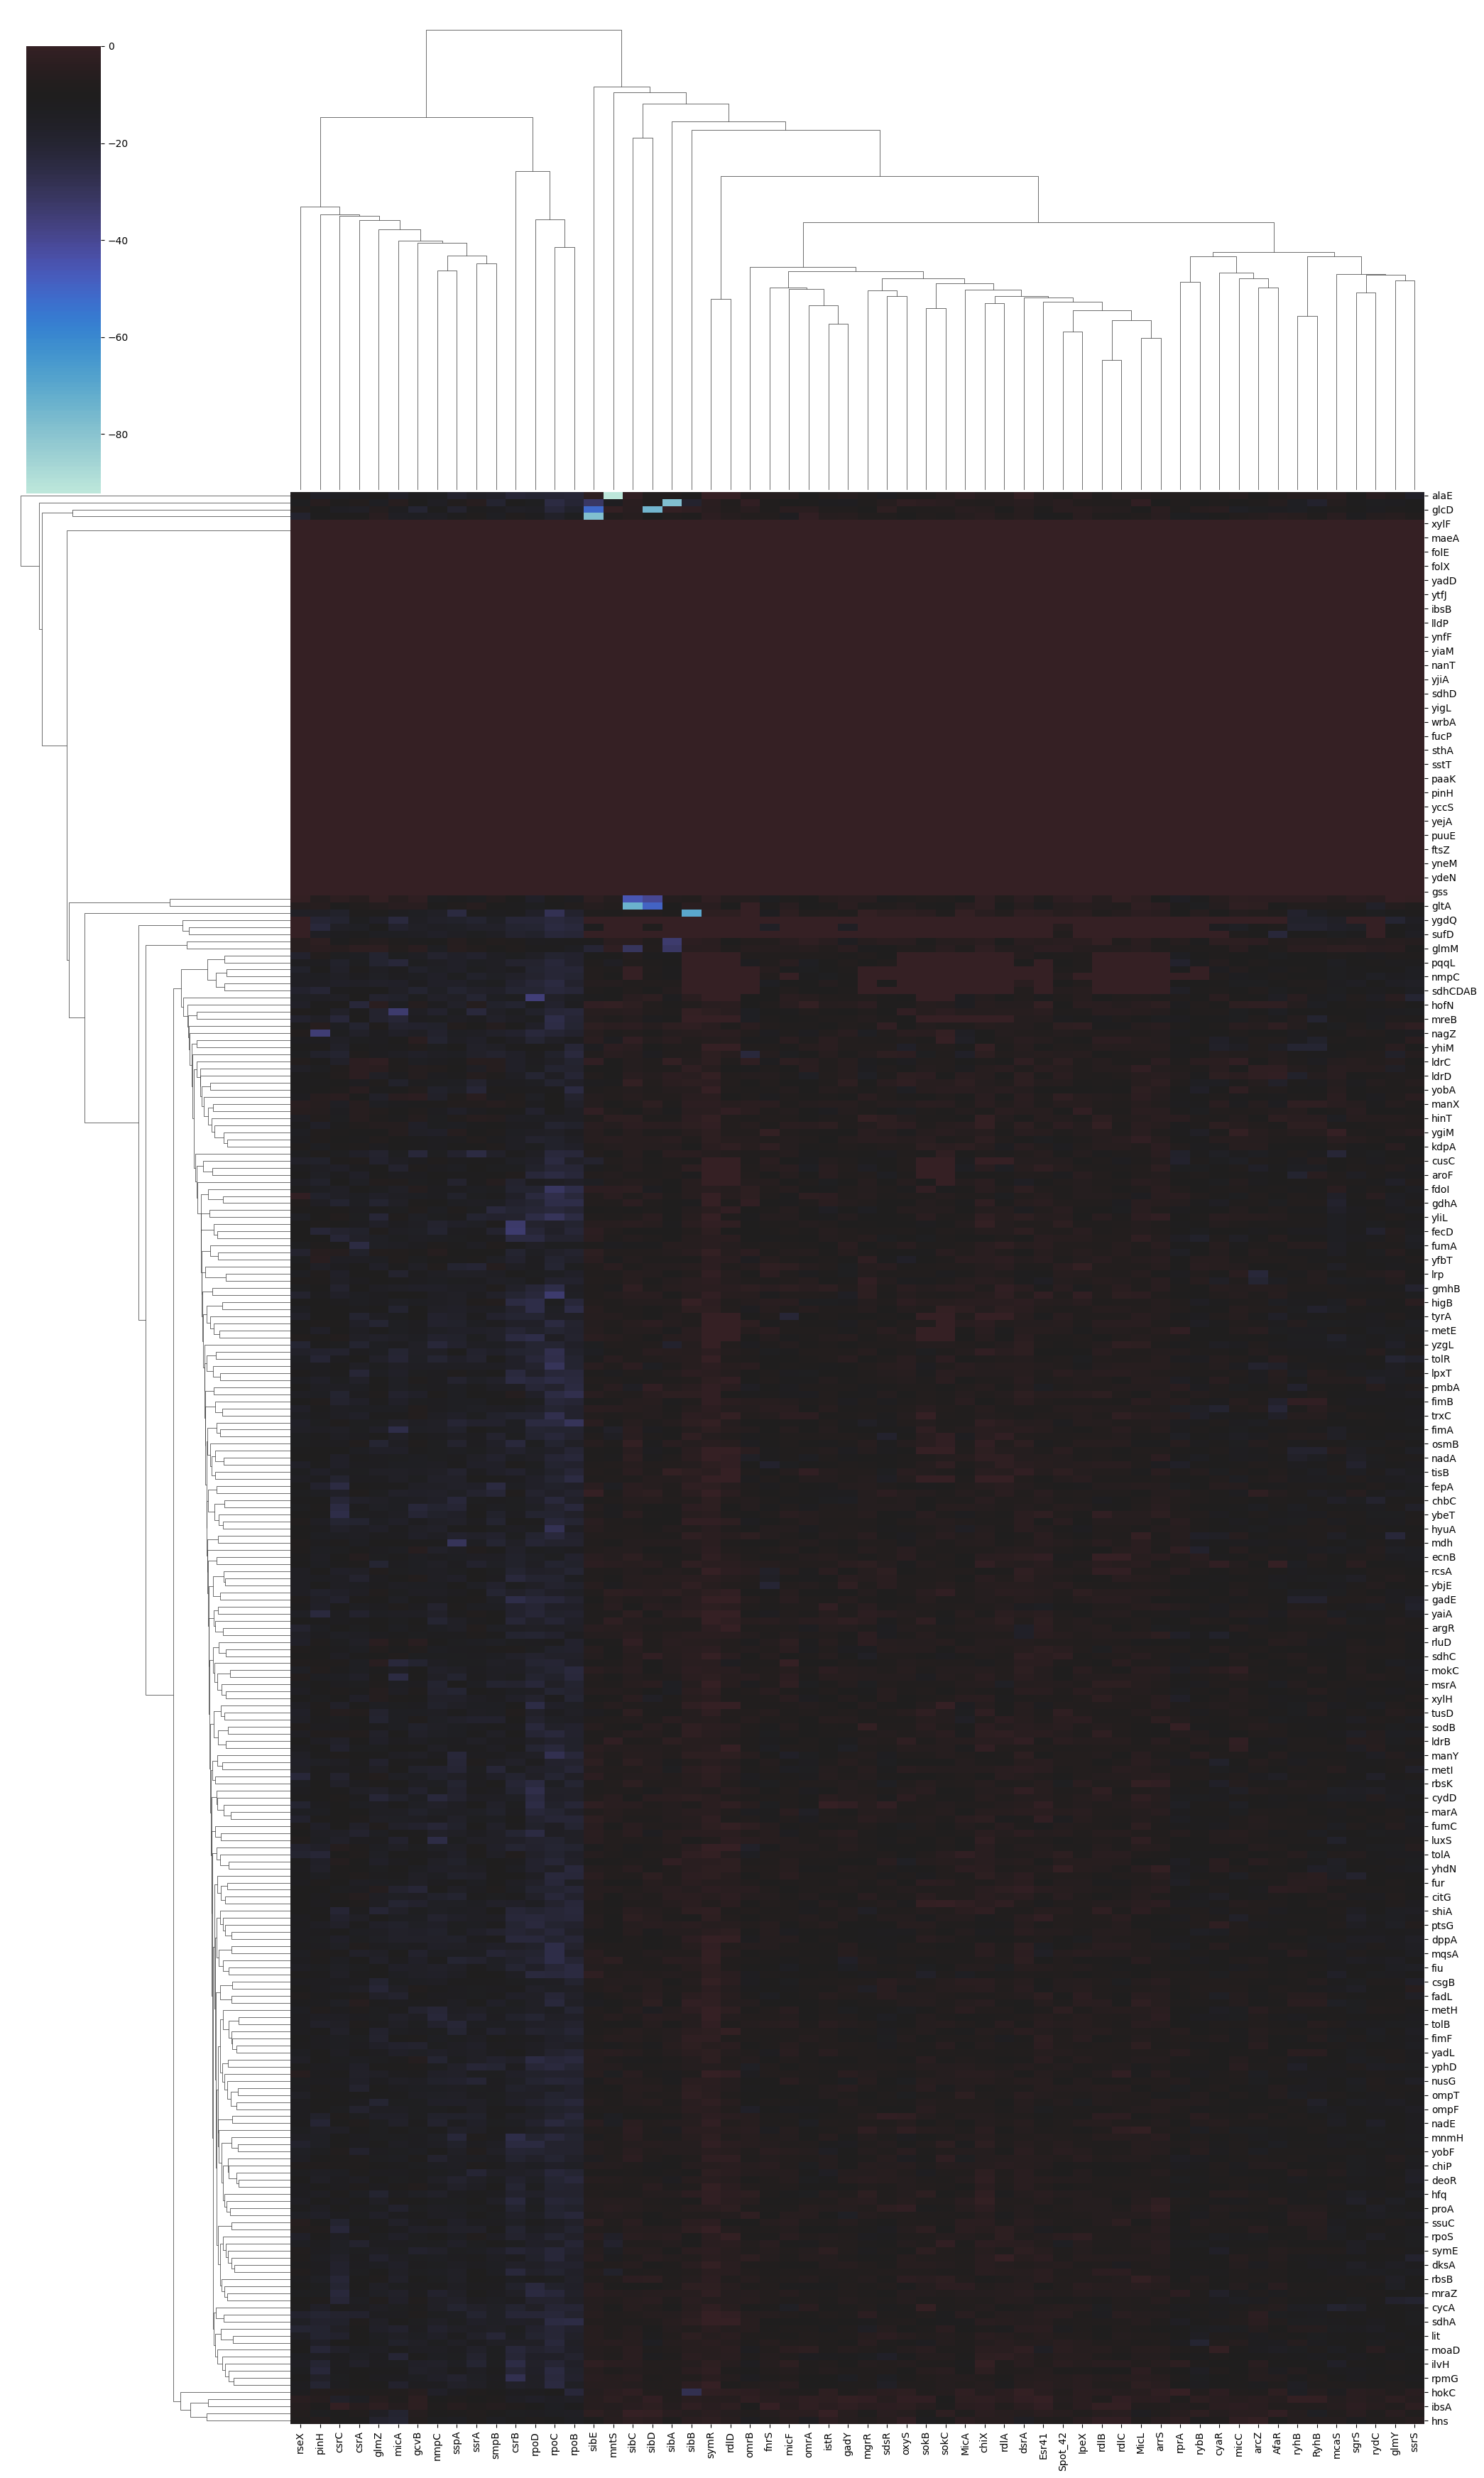

In [24]:
fig = plt.figure(figsize=(21, 27))
sns.clustermap(energies, center=-10, figsize=(21, 35), cmap= 'icefire') # Spectral, cubehelix, vlag
# plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)')

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2100x2700 with 0 Axes>

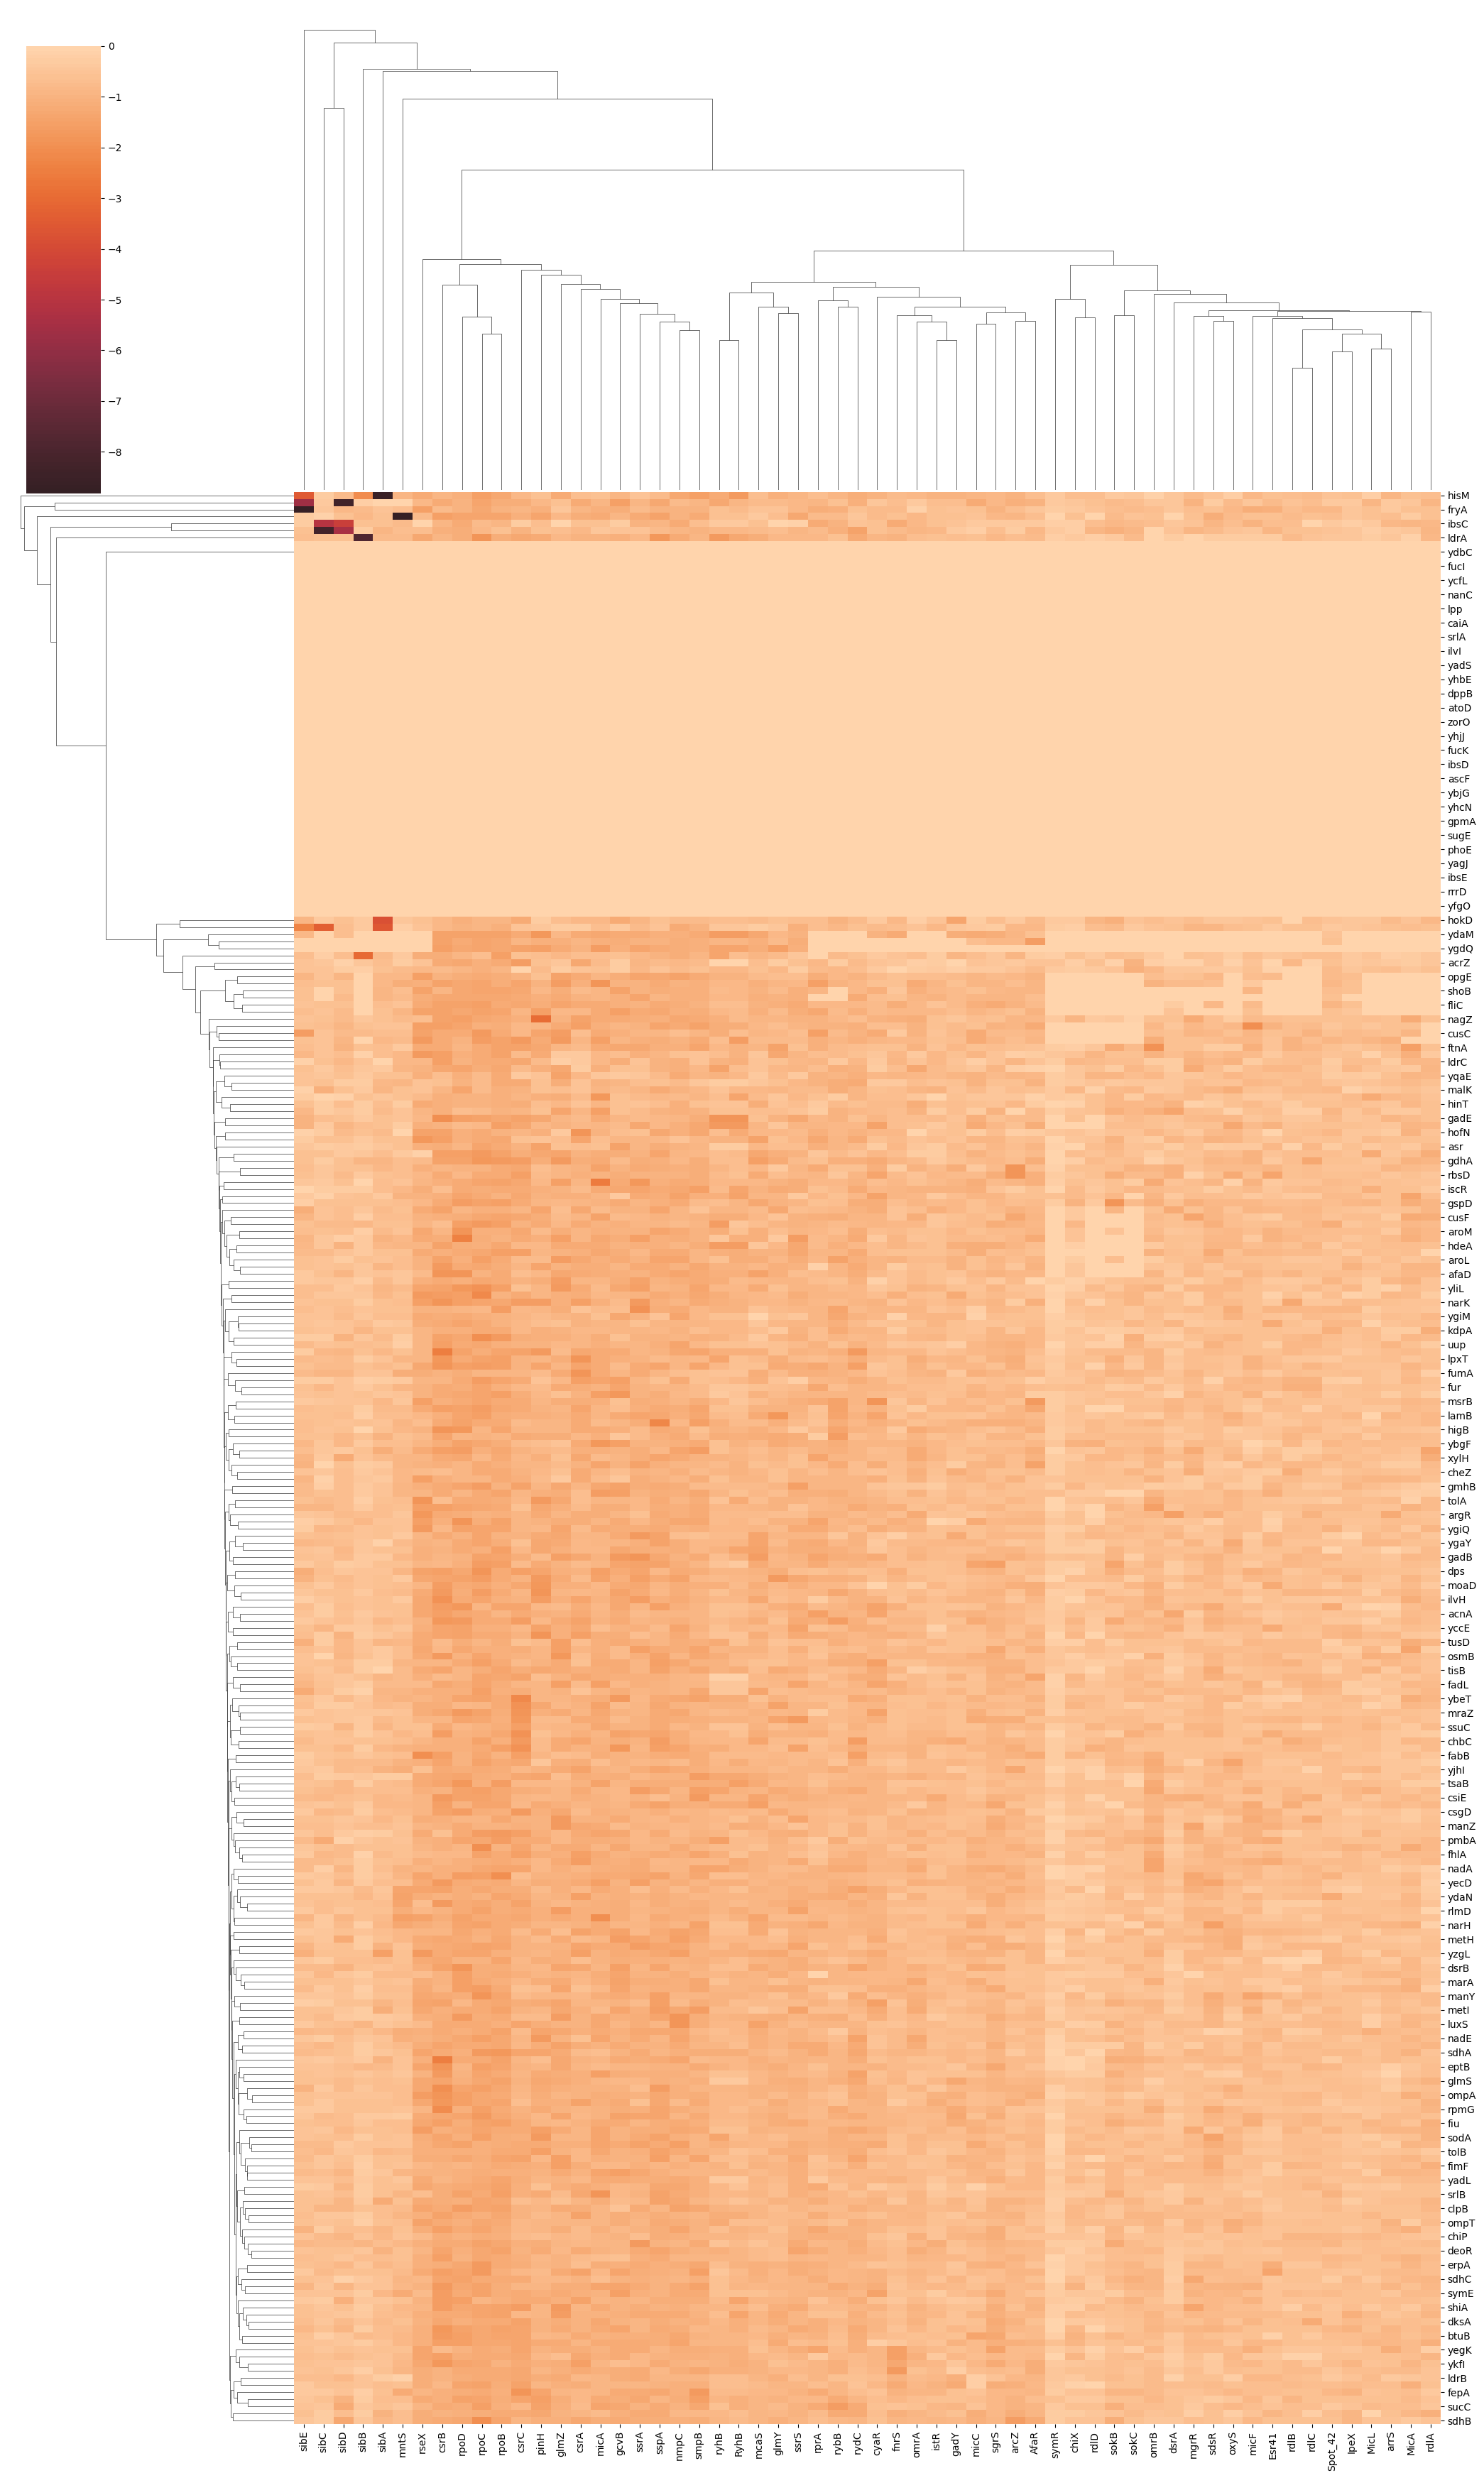

In [25]:
fig = plt.figure(figsize=(21, 27))
sns.clustermap(energies_norm, center=-10, figsize=(21, 35), cmap= 'icefire') # Spectral, cubehelix, vlag
# plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)')

## Assess specificity

In [26]:
specificity = pd.DataFrame(data=np.zeros_like(np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T),
                           columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

for s in data[data['Category 1'] != 'mRNA']['Interactor 1'].unique():
    specificity.loc[list(data[(data['Interactor 1'] == s) & (data['Category 2'] == 'mRNA') & (
        ~data['Sequence 2'].isna())]['Interactor 2'].unique()), s] = 1
    
for s in data[data['Category 2'] != 'mRNA']['Interactor 2'].unique():
    specificity.loc[list(data[(data['Interactor 2'] == s) & (data['Category 1'] == 'mRNA') & (
        ~data['Sequence 1'].isna())]['Interactor 1'].unique()), s] = 1

/tmp/ipykernel_93845/2588694973.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


Text(0.5, 1.0, 'sRNA - mRNA interactions (from RNAInter)')

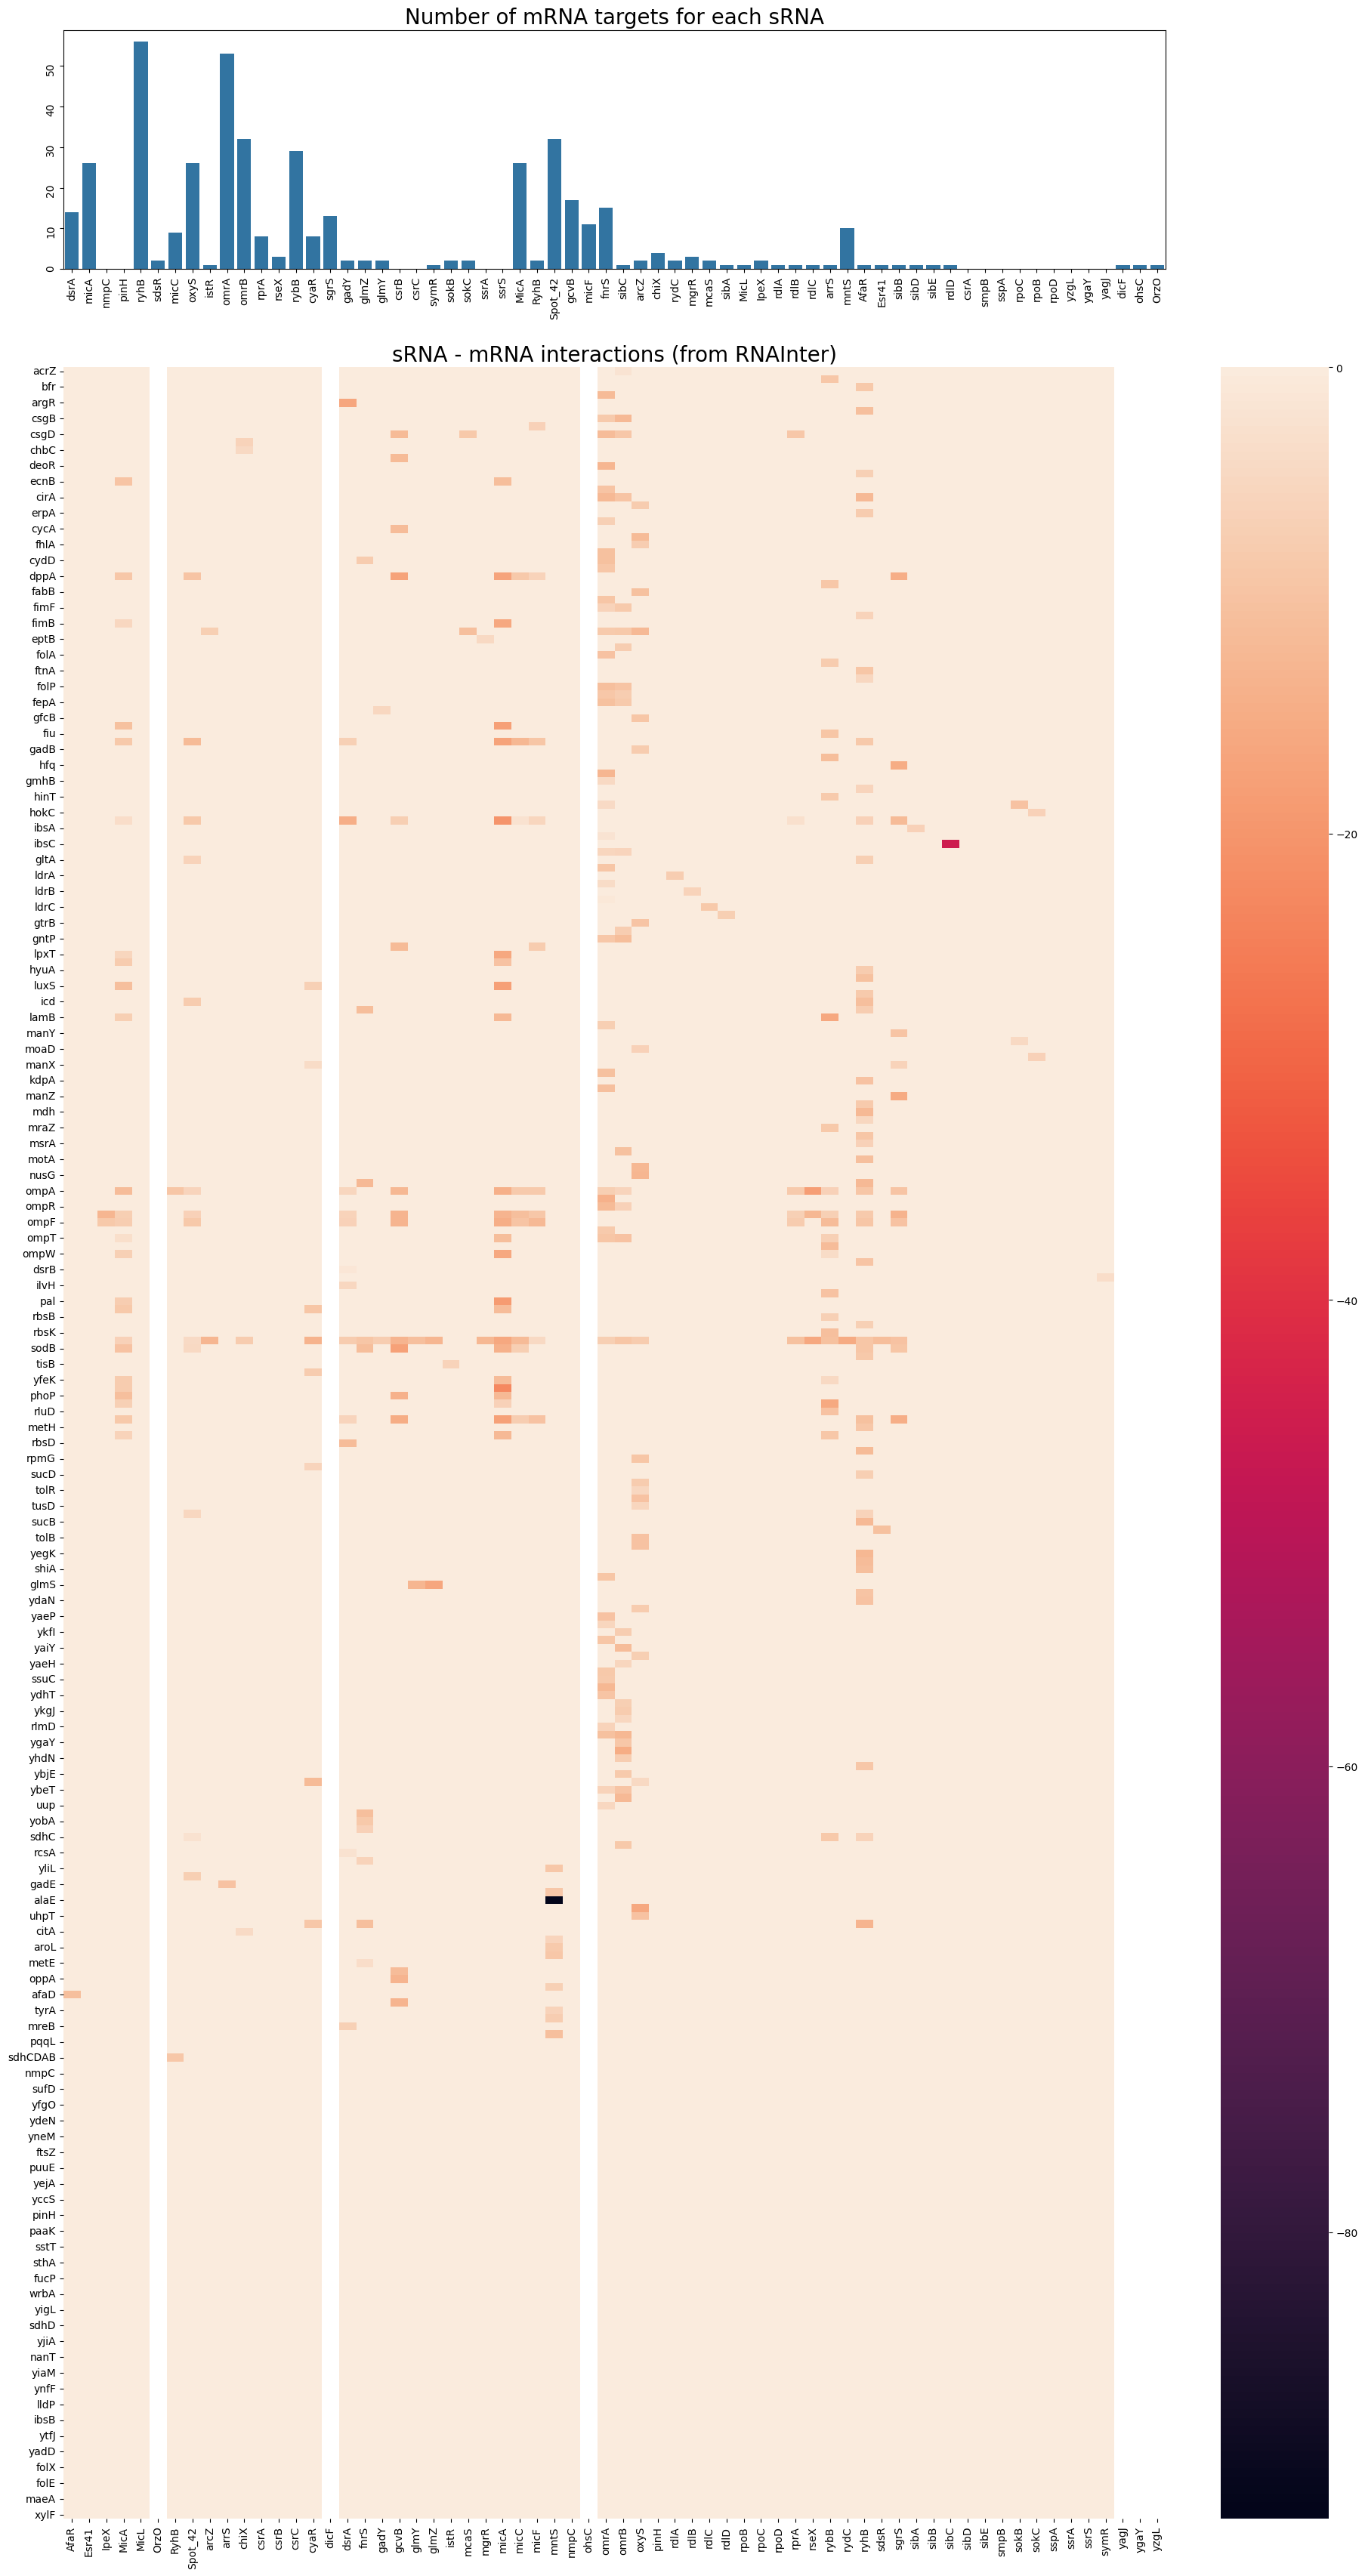

In [27]:
fig, axs = plt.subplots(2,1,figsize=(18, 34), gridspec_kw={'height_ratios': [1, 9]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

sns.barplot(specificity.sum(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
axs[0].tick_params(rotation=90)
axs[0].set_title('Number of mRNA targets for each sRNA', fontsize=20)


sns.heatmap(specificity * energies, ax=axs[1])
axs[1].set_title('sRNA - mRNA interactions (from RNAInter)', fontsize=20)



In [60]:
# sns.scatterplot(x=(specificity * energies).sum(axis=0) / (np.where(specificity.sum(axis=0) == 0, 1, specificity.sum(axis=0))),
#                 y=energies.sum(axis=0) / (energies < 0).sum(axis=0))

# plt.xlabel('Average binding energy of documented interactions per sRNA')
# plt.ylabel('Average binding energy for all mRNAs per sRNA')
# plt.title('')

In [32]:
specificity_missing_cols = [c for c in specificity.columns if c not in energies.columns]
print('Not including the following documented interaction targets likely due to missing sequence:',
      specificity_missing_cols)
specificity = specificity.drop(columns=specificity_missing_cols)

Not including the following documented interaction targets likely due to missing sequence: ['yzgL', 'ygaY', 'yagJ', 'dicF', 'ohsC', 'OrzO']


Text(0.5, 1.0, 'Documented interaction (from RNAInter)')

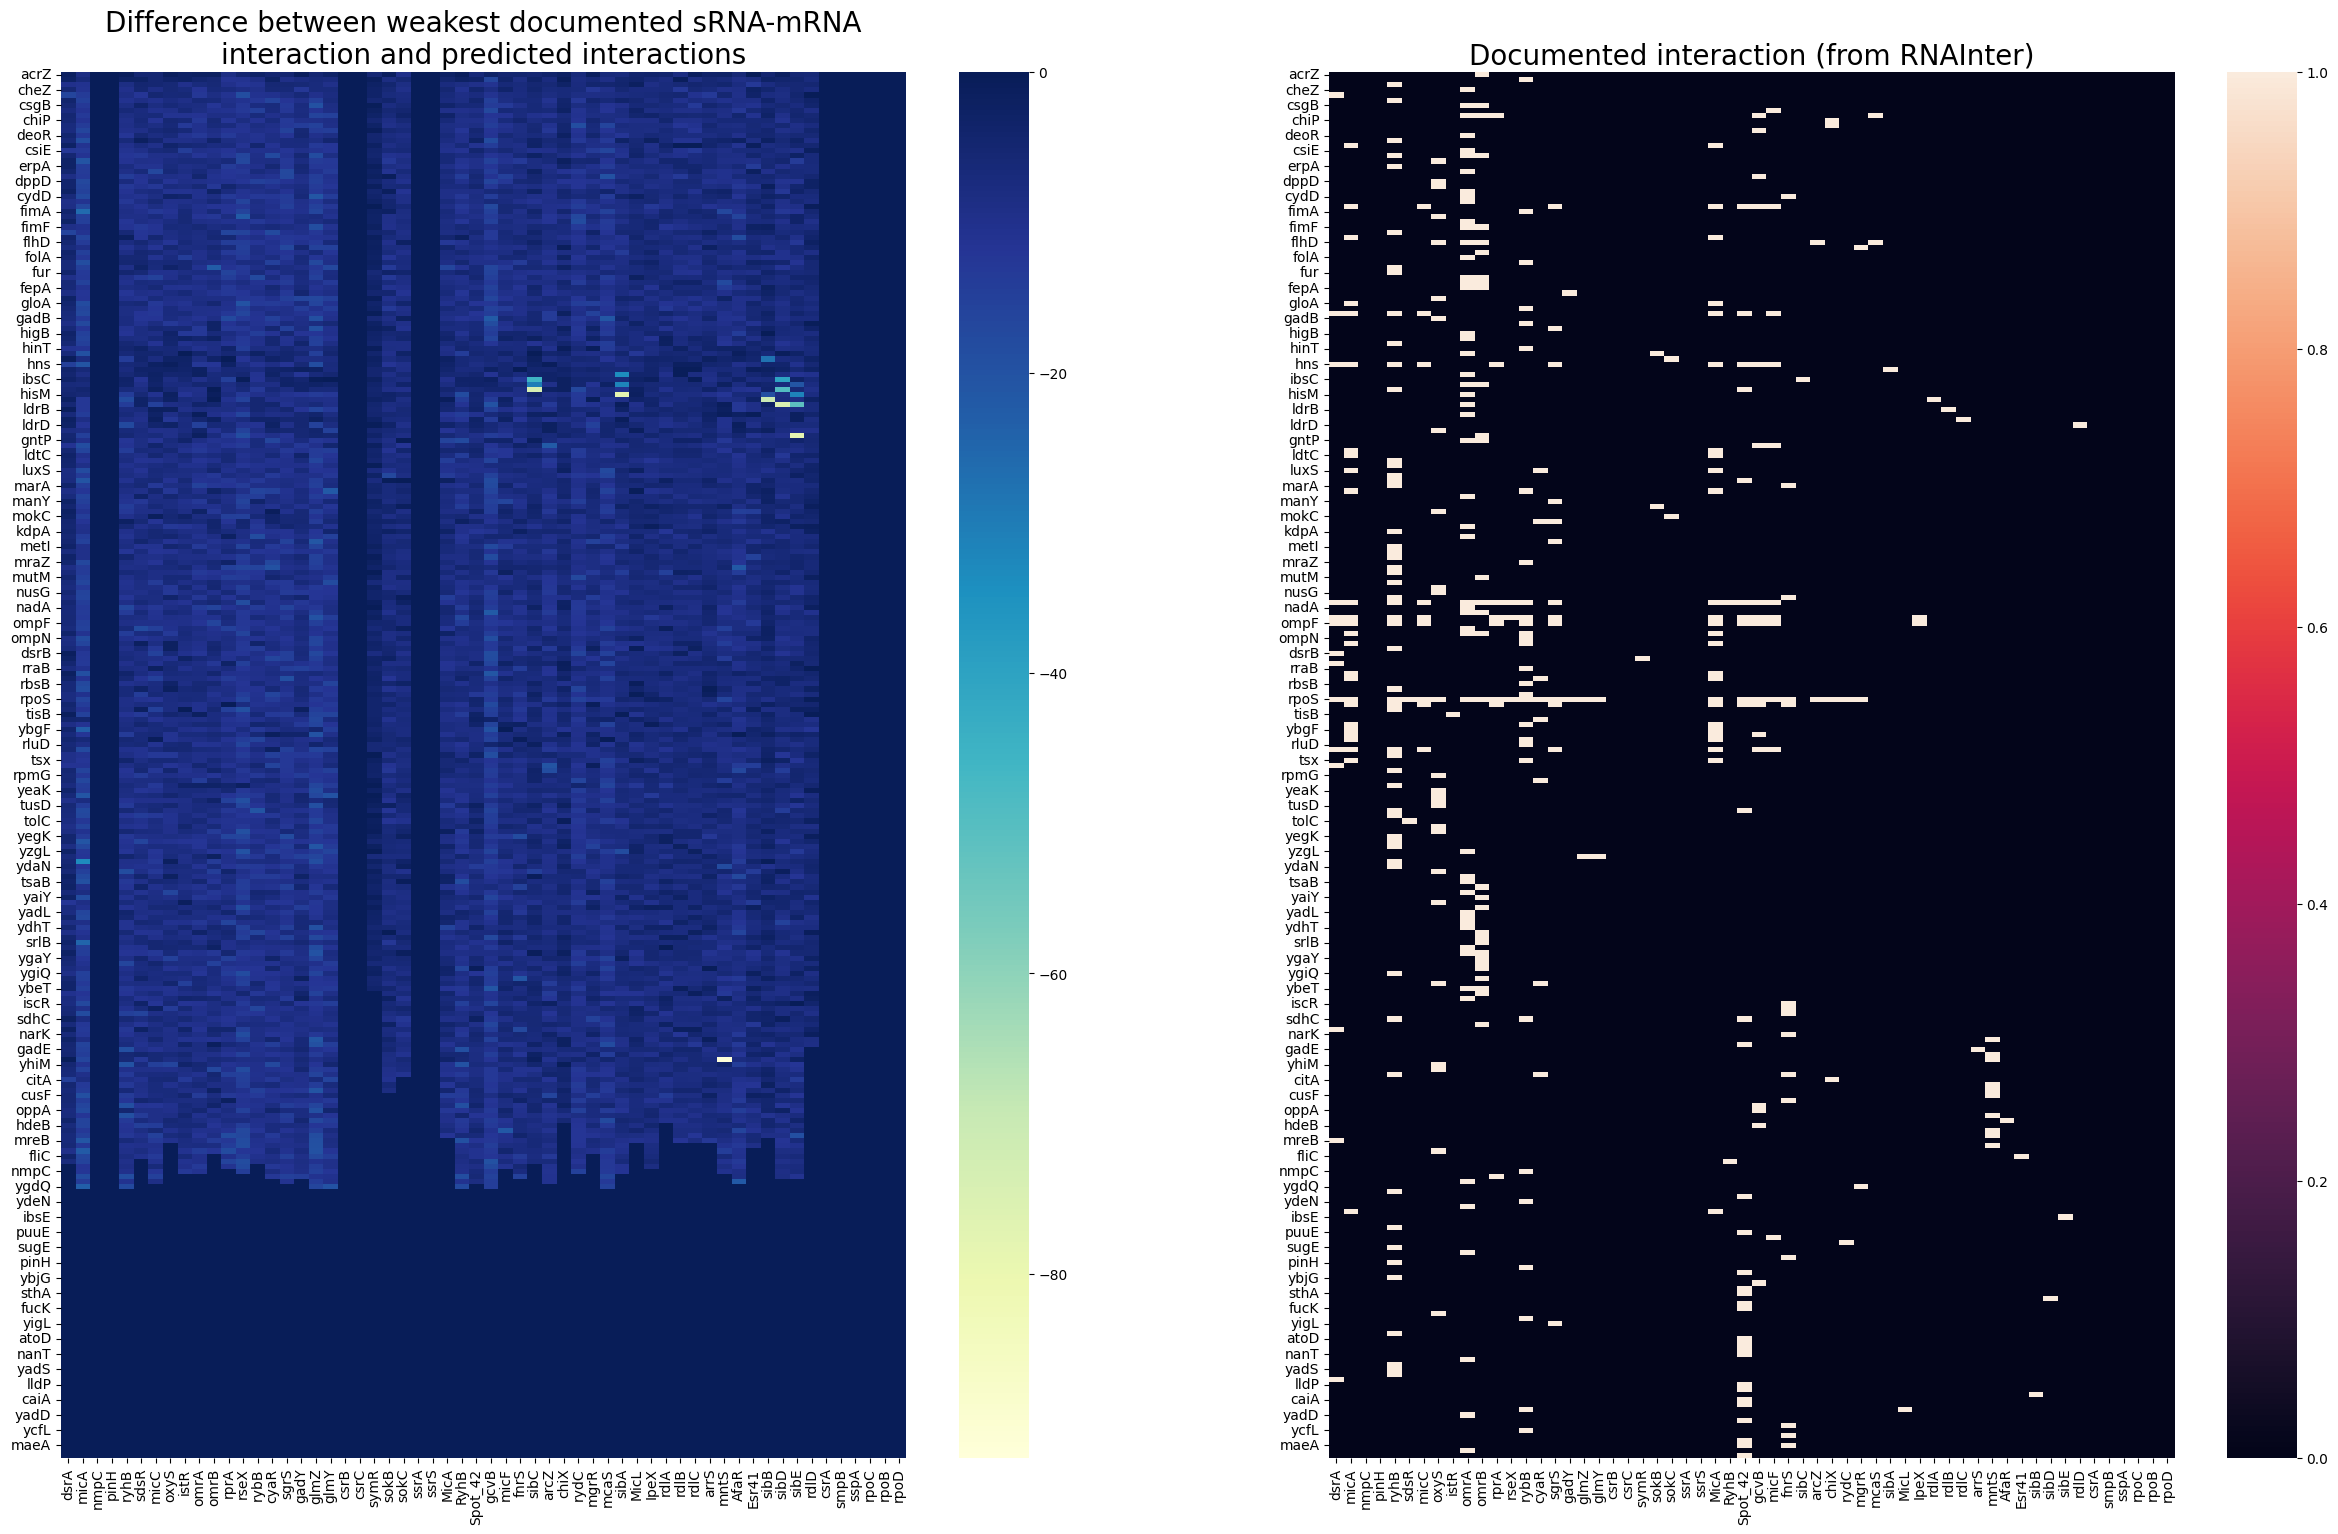

In [33]:
# threshold_binding_E = (specificity * energies).min(axis=0)
threshold_binding_E = np.where(specificity.sum(axis=0) > 0, (specificity * energies).max(axis=0), 0)

plt.figure(figsize=(30, 18))
ax = plt.subplot(1, 2, 1)
mask = (np.ones_like(energies) * (specificity.sum(axis=0) > 0).to_numpy()[None, :])
sns.heatmap(energies * mask - (
    np.ones_like(energies) * threshold_binding_E[None, :]), cmap='YlGnBu')
plt.title('Difference between weakest documented sRNA-mRNA\ninteraction and predicted interactions', fontsize=20)

ax = plt.subplot(1, 2, 2)
sns.heatmap(specificity)
plt.title('Documented interaction (from RNAInter)', fontsize=20)